# Introduction

In this notebook two datasets will be analysed both from experimental data. First dataset is for a single zone constant air volume (SZCAV) AHU and second one for a single zone variable air volume (SZVAV) AHU.

Following data was used in the dataset:

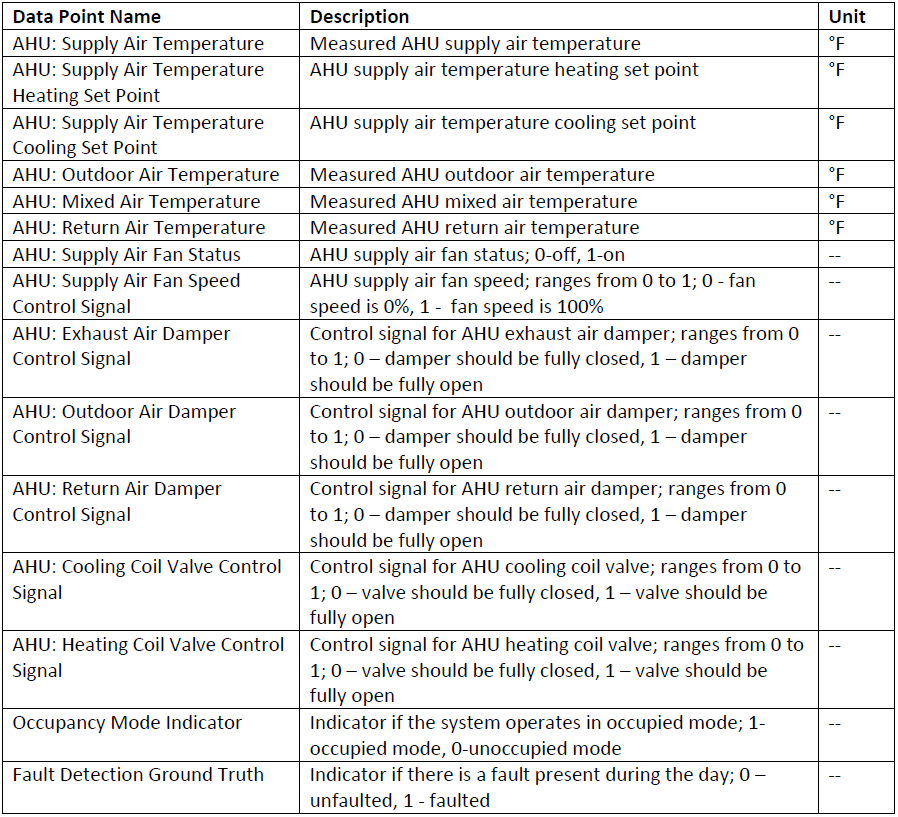


The faults in the dataset were imposed by experiments and each fault was imposed to the unit at 12am and lasted for a day.

Fault imposed in single-zone constant air volume AHU are as follow:

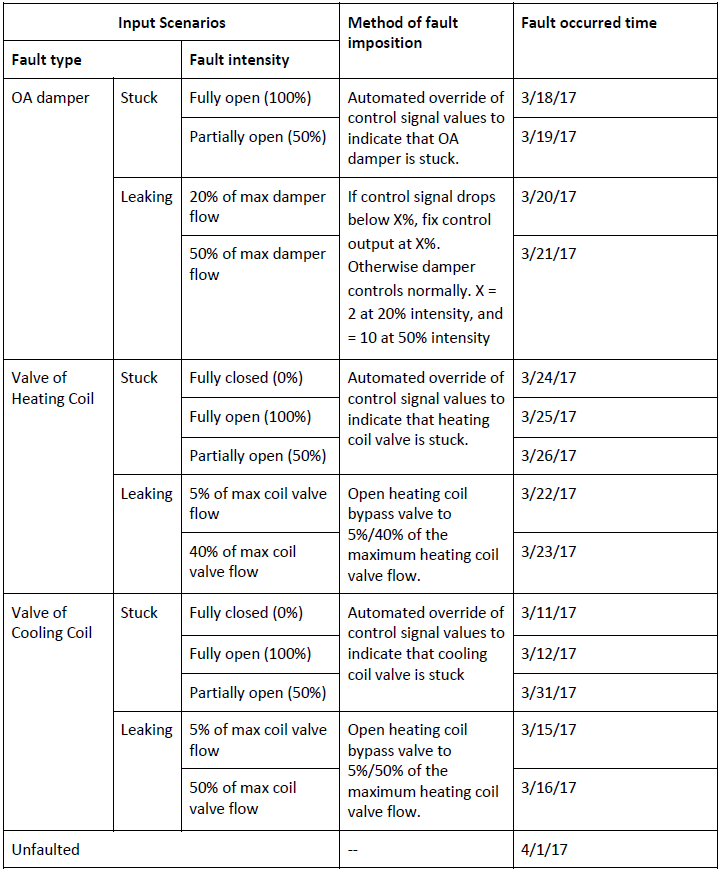

Fault imposed in single-zone variable air volume AHU are as follow:

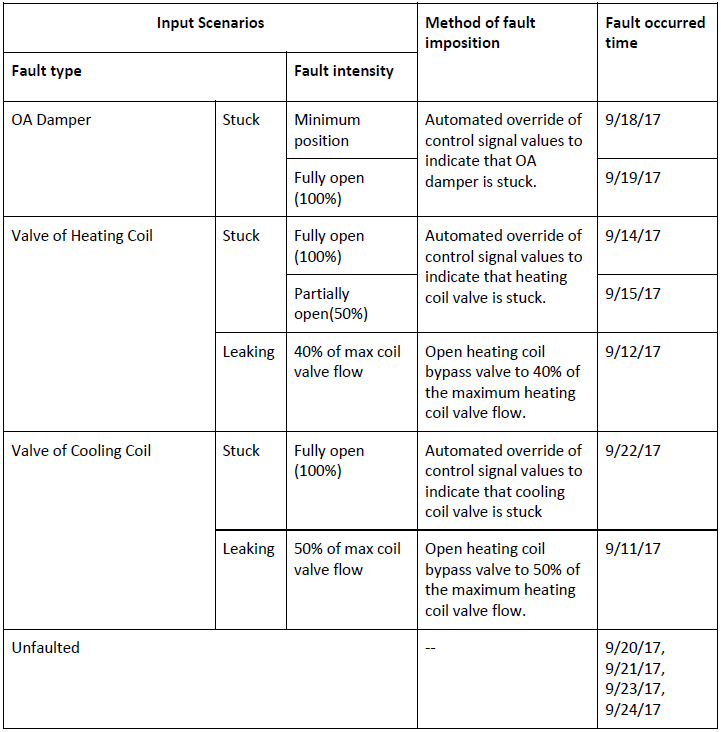

# Import of the relevant libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings

In [ ]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings("ignore")

# Single-zone constant air volume AHU

## Data exploration and feature engineering

In [3]:
raw_data_cav = pd.read_csv('SZCAV.csv')

In [4]:
raw_data_cav.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
2560,3/12/2017 18:40,50.93,50.00,86.0,60.99,59.53,59.39,1,0.5,0.00,1.0,0.0,0.0,0.000000,0,1
9305,3/20/2017 11:05,70.17,69.83,86.0,56.77,67.01,70.16,1,0.5,0.15,1.0,0.0,0.0,0.258214,1,1
3047,3/15/2017 2:47,66.26,50.00,86.0,56.26,67.63,67.76,1,0.5,0.00,1.0,0.0,0.0,0.000000,0,1
7763,3/19/2017 9:23,64.90,60.20,86.0,56.78,65.02,67.94,1,0.5,0.15,1.0,0.0,0.0,0.000000,1,1
3337,3/15/2017 7:37,70.96,70.45,86.0,49.62,65.83,70.91,1,0.5,0.15,1.0,0.0,0.0,0.286567,1,1


In [5]:
raw_data_cav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Datetime                                       21600 non-null  object 
 1   AHU: Supply Air Temperature                    21600 non-null  float64
 2   AHU: Supply Air Temperature Heating Set Point  21600 non-null  float64
 3   AHU: Supply Air Temperature Cooling Set Point  21600 non-null  float64
 4   AHU: Outdoor Air Temperature                   21600 non-null  float64
 5   AHU: Mixed Air Temperature                     21600 non-null  object 
 6   AHU: Return Air Temperature                    21600 non-null  float64
 7   AHU: Supply Air Fan Status                     21600 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal       21600 non-null  float64
 9   AHU: Outdoor Air Damper Control Signal         216

Dataset doesn't contain any null data, but column "AHU: Mixed Air Temperature" and "Datetime" needs to have datatype changed.

In [6]:
raw_data_cav['Datetime'] = pd.to_datetime(raw_data_cav['Datetime'])

In [7]:
# Changing column values to numeric values, changing all defective data to NaN
raw_data_cav['AHU: Mixed Air Temperature'] = pd.to_numeric(raw_data_cav['AHU: Mixed Air Temperature'],errors='coerce')

In [8]:
raw_data_cav['AHU: Mixed Air Temperature'].isna().sum()

90

There are 90 rows with defective data in "AHU: Mixed Air Temperature" which compared to the size of the dataset is small fraction, so we can safely delete all this rows.

In [9]:
raw_data_cav.dropna(inplace=True)

In [10]:
raw_data_cav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21510 entries, 0 to 21599
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Datetime                                       21510 non-null  datetime64[ns]
 1   AHU: Supply Air Temperature                    21510 non-null  float64       
 2   AHU: Supply Air Temperature Heating Set Point  21510 non-null  float64       
 3   AHU: Supply Air Temperature Cooling Set Point  21510 non-null  float64       
 4   AHU: Outdoor Air Temperature                   21510 non-null  float64       
 5   AHU: Mixed Air Temperature                     21510 non-null  float64       
 6   AHU: Return Air Temperature                    21510 non-null  float64       
 7   AHU: Supply Air Fan Status                     21510 non-null  int64         
 8   AHU: Supply Air Fan Speed Control Signal       21510 non

In [11]:
raw_data_cav.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
count,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000
mean,68.584346,56.308631,80.418358,54.732109,65.155592,69.822446,0.999303,0.499675,0.250513,0.834856,0.082572,0.128883,0.139289,0.502092,0.933752
std,7.798999,9.889737,11.928306,5.366600,5.752576,5.199783,0.026399,0.012752,0.363272,0.365543,0.182772,0.326036,0.247166,0.500007,0.248721
min,49.210000,50.000000,50.000000,44.600000,46.280000,58.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.860000,50.000000,86.000000,50.590000,62.650000,66.180000,1.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,67.540000,50.000000,86.000000,53.700000,65.260000,69.150000,1.000000,0.500000,0.150000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,72.540000,61.850000,86.000000,57.610000,68.000000,72.330000,1.000000,0.500000,0.150000,1.000000,0.000000,0.000000,0.279320,1.000000,1.000000
max,88.830000,86.000000,86.000000,71.180000,80.870000,83.230000,1.000000,0.500000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000


Data seems to be cleaned. Now it's time to select relevant data for model building.

In [12]:
data_cav = raw_data_cav.copy()

<AxesSubplot:>

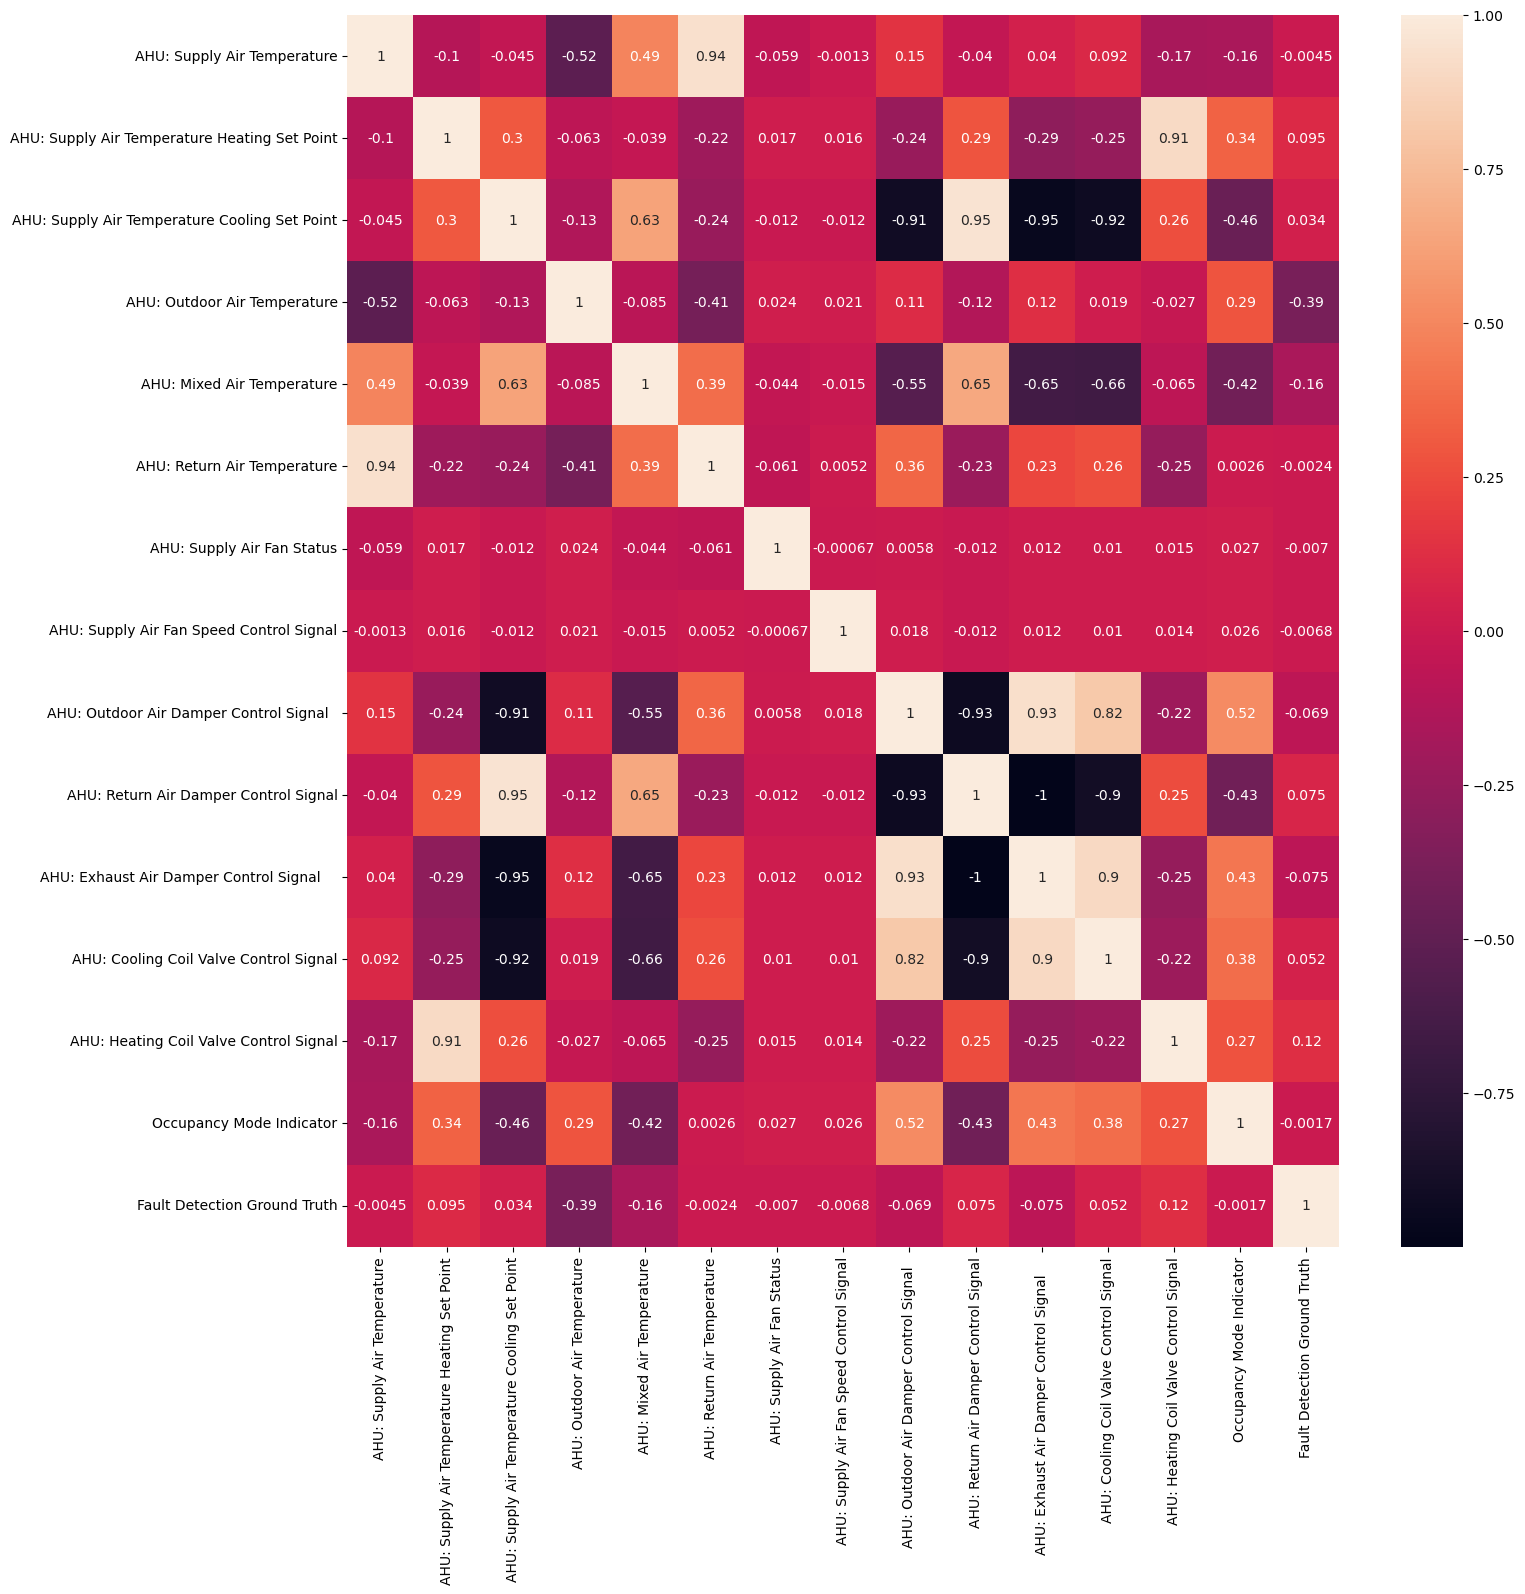

In [13]:
plt.figure(figsize=(16,16))
sns.heatmap(data_cav.corr(), annot=True)

Columns:"AHU: Outdoor Air Damper Control Signal", "AHU: Return Air Damper Control Signal", "AHU: Exhaust Air Damper Control Signal" are highly correlated so we will leave only one. Columns "AHU: Supply Air Temperature Cooling Set Point" and "AHU: Cooling Coil Valve Control Signal" are also highly correlated to the previous columns but they have diffrent characteristic and value units so they will stay.

In [14]:
data_cav.drop(['AHU: Return Air Damper Control Signal', 'AHU: Exhaust Air Damper Control Signal    '], axis=1, inplace=True)

<AxesSubplot:>

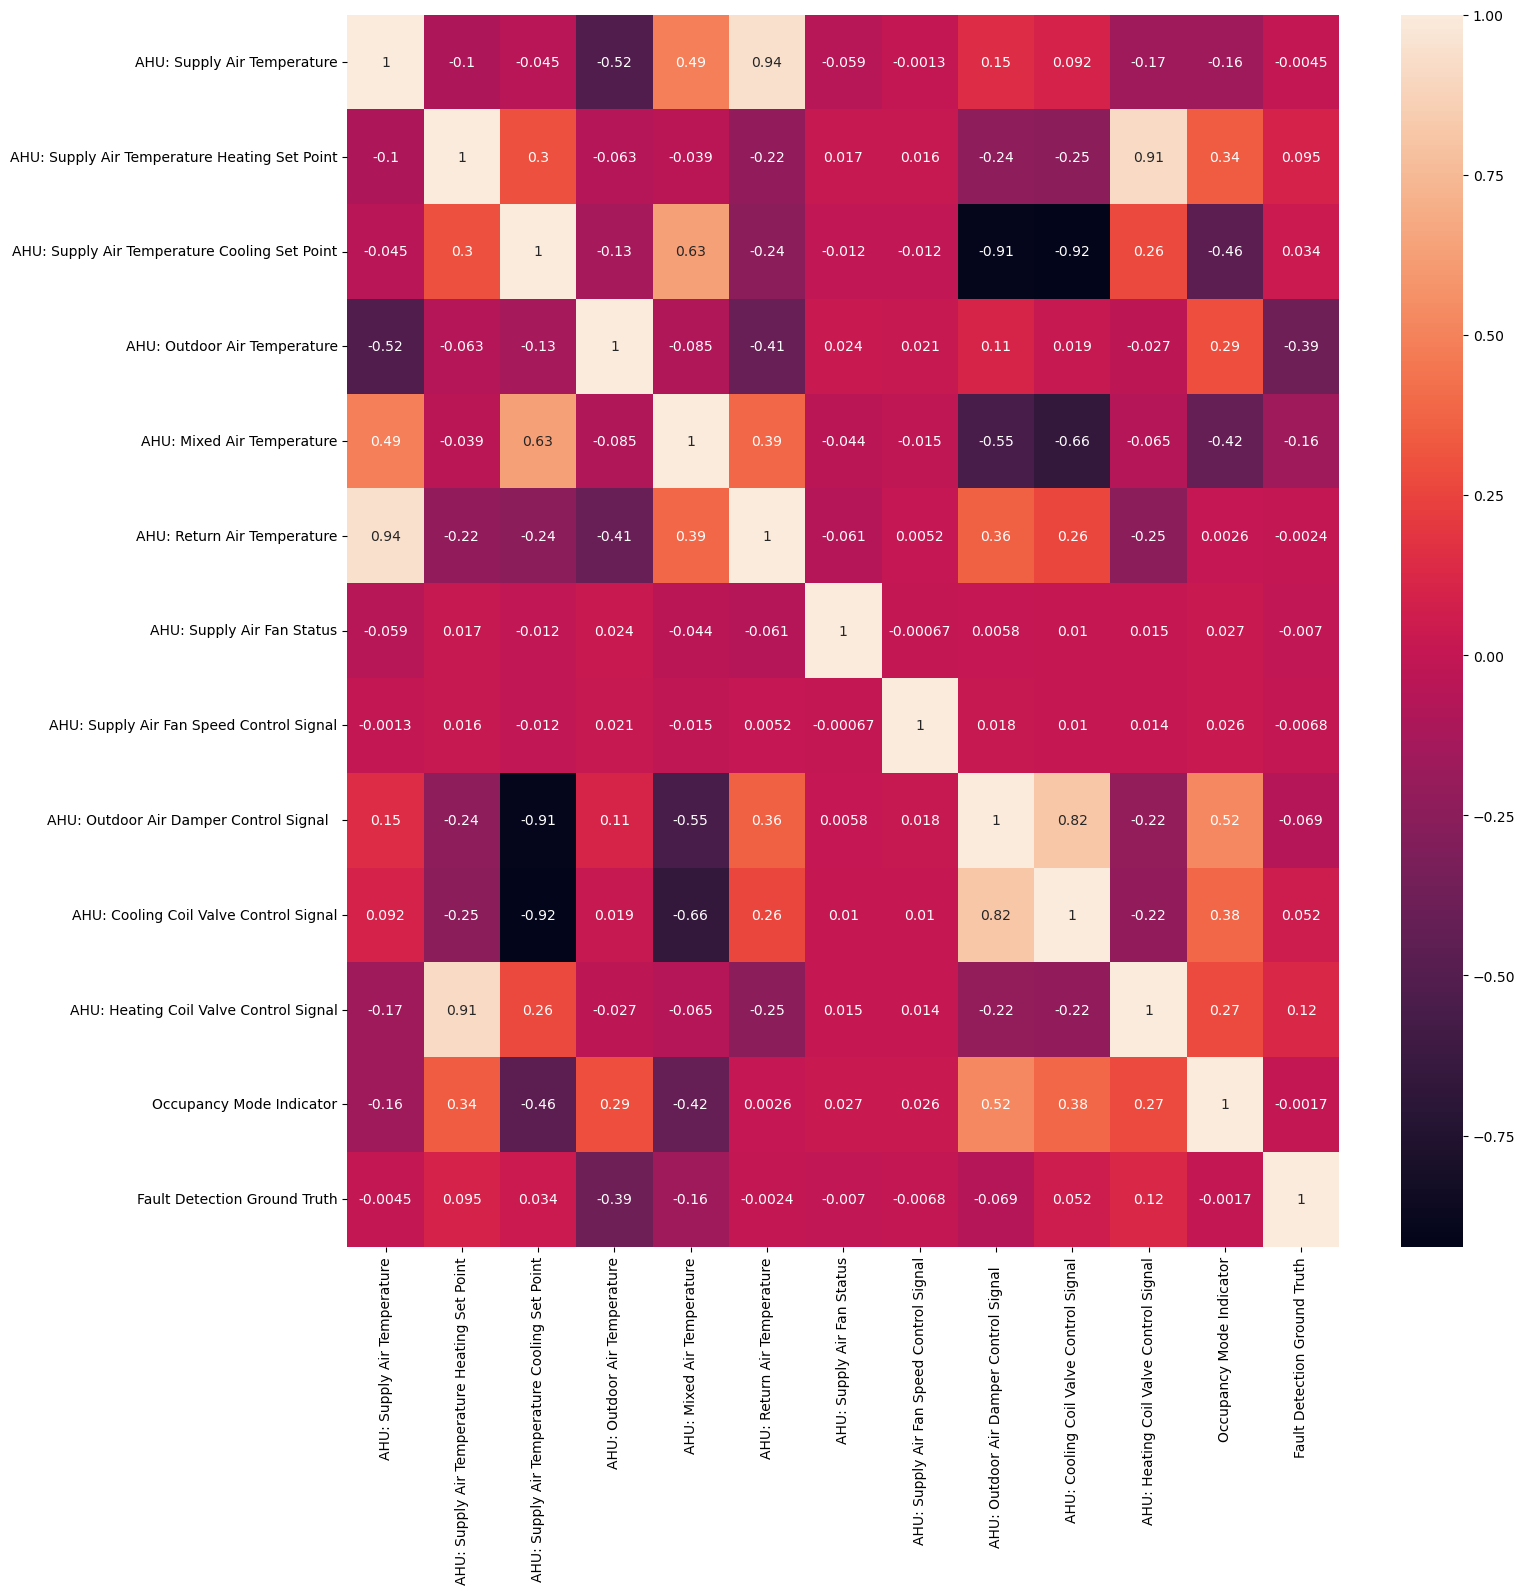

In [15]:
plt.figure(figsize=(16,16))
sns.heatmap(data_cav.corr(), annot=True)

Feature data seems to be ready for model building. Column "Fault Detection Ground Truth" however contains data about vastly different faults so as in the other datasets target column for each kind of fault will be created.

In [16]:
# Preparing function to convert data format used in dataset description to DateTime format.
def convert_date(date_str):
    return pd.to_datetime(date_str, format='%m/%d/%y')

In [17]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('9/18/17'), 
                  convert_date('9/19/17')]
heat_vlv_fault_dates = [convert_date('9/14/17'), 
                        convert_date('9/15/17'), 
                        convert_date('9/12/17')]
cool_vlv_fault_dates = [convert_date('9/22/17'), 
                        convert_date('9/11/17')]
OA_fault_dates = [convert_date('3/18/17'), 
                  convert_date('3/19/17'), 
                  convert_date('3/20/17'), 
                  convert_date('3/21/17')]
heat_vlv_fault_dates = [convert_date('3/24/17'), 
                        convert_date('3/25/17'), 
                        convert_date('3/26/17'),
                        convert_date('3/22/17'),
                        convert_date('3/23/17')]
cool_vlv_fault_dates = [convert_date('3/11/17'), 
                        convert_date('3/12/17'), 
                        convert_date('3/31/17'),
                        convert_date('3/15/17'),
                        convert_date('3/16/17')]

In [18]:
# Creating and filling faults column with values according to the dates given earlier.
data_cav['OA_fault'] = 0
data_cav['heat_vlv_fault'] = 0
data_cav['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [19]:
X = data_cav.drop(['Datetime','Fault Detection Ground Truth', 'OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [20]:
y_oa = data_cav['OA_fault']
y_heat = data_cav['heat_vlv_fault']
y_cool = data_cav['cool_vlv_fault']

### Train test split

In [21]:
X_train_oa, X_test_oa, y_train_oa, y_test_oa = train_test_split(X, y_oa, test_size=0.1, shuffle=True)
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(X, y_heat, test_size=0.1, shuffle=True)
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(X, y_cool, test_size=0.1, shuffle=True)

NameError: name 'train_test_split' is not defined

### Classification models training

In [ ]:
# preparing list of classifiacation algorithms for comparison and to choose the best one
classifiers = [['KNeighborsClassifier', KNeighborsClassifier()],
              ['MLPClassifier',MLPClassifier()],
              ['AdaBoostClassifier',AdaBoostClassifier()],
              ['GradientBoostingClassifier',GradientBoostingClassifier()],
              ['CatBoostClassifier', CatBoostClassifier()],
              ['XGBClassifier', XGBClassifier()],
              ['BaggingClassifier', BaggingClassifier()],
              ['RandomForestClassifier', RandomForestClassifier()],
              ['DecisionTreeClassifier', DecisionTreeClassifier()],
              ['LogisticRegression', LogisticRegression()]]

In [ ]:
# Dataframes to store the evaluation parameters.
Acc_oa_cav = pd.DataFrame(index=None, columns=['model','train_accuracy','test_accuracy','train_precision','test_precision',
                                        'train_recall','test_recall','train_f1','test_f1'])
Acc_heat_cav = pd.DataFrame(index=None, columns=['model','train_accuracy','test_accuracy','train_precision','test_precision',
                                        'train_recall','test_recall','train_f1','test_f1'])
Acc_cool_cav = pd.DataFrame(index=None, columns=['model','train_accuracy','test_accuracy','train_precision','test_precision',
                                        'train_recall','test_recall','train_f1','test_f1'])

In [ ]:
# Lists to store the models.
models_oa_cav = []
models_heat_cav = []
models_cool_cav = []

In [ ]:
# Loop created to train and evaluate each model for outside air damper fault.
for mod in classifiers:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train_oa,y_train_oa)
    models_oa_cav.append(model)
    y_pred_train = model.predict(X_train_oa)
    y_pred_test = model.predict(X_test_oa)
    acc_train = accuracy_score(y_train_oa, y_pred_train)
    acc_test = accuracy_score(y_test_oa, y_pred_test)
    prec_train = precision_score(y_train_oa, y_pred_train)
    prec_test = precision_score(y_test_oa, y_pred_test)    
    rec_train = recall_score(y_train_oa, y_pred_train)
    rec_test = recall_score(y_test_oa, y_pred_test) 
    f1_train = f1_score(y_train_oa, y_pred_train)
    f1_test = f1_score(y_test_oa, y_pred_test)
    
    Acc_oa_cav = Acc_oa_cav.append(pd.Series({'model':name,
                                'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}),ignore_index=True)

In [ ]:
# Creating the loop to train and evaluate each model for heating valve leakage fault.
for mod in classifiers:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train_heat,y_train_heat)
    models_heat_cav.append(model)
    y_pred_train = model.predict(X_train_heat)
    y_pred_test = model.predict(X_test_heat)
    acc_train = accuracy_score(y_train_heat, y_pred_train)
    acc_test = accuracy_score(y_test_heat, y_pred_test)
    prec_train = precision_score(y_train_heat, y_pred_train)
    prec_test = precision_score(y_test_heat, y_pred_test)    
    rec_train = recall_score(y_train_heat, y_pred_train)
    rec_test = recall_score(y_test_heat, y_pred_test) 
    f1_train = f1_score(y_train_heat, y_pred_train)
    f1_test = f1_score(y_test_heat, y_pred_test)
    
    Acc_heat_cav = Acc_heat_cav.append(pd.Series({'model':name,
                                'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}),ignore_index=True)

In [ ]:
# Creating the loop to train and evaluate each model for cooling valve leakage fault.
for mod in classifiers:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train_cool,y_train_cool)
    models_cool_cav.append(model)
    y_pred_train = model.predict(X_train_cool)
    y_pred_test = model.predict(X_test_cool)
    acc_train = accuracy_score(y_train_cool, y_pred_train)
    acc_test = accuracy_score(y_test_cool, y_pred_test)
    prec_train = precision_score(y_train_cool, y_pred_train)
    prec_test = precision_score(y_test_cool, y_pred_test)    
    rec_train = recall_score(y_train_cool, y_pred_train)
    rec_test = recall_score(y_test_cool, y_pred_test) 
    f1_train = f1_score(y_train_cool, y_pred_train)
    f1_test = f1_score(y_test_cool, y_pred_test)
    
    Acc_cool_cav = Acc_cool_cav.append(pd.Series({'model':name,
                                'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}),ignore_index=True)

## Models evaluation

In [ ]:
print(Acc_oa_cav)

In [ ]:
print(Acc_heat_cav)

In [ ]:
print(Acc_cool_cav)

Most of the models perfored excellent without any tuning and balancing. At this level of performance these models have achieved, it is difficult to choose the best of them, and we can probably choose any one. Perhaps just the one that is the fastest and takes up the least space.

## Feature importances

In [ ]:
plt.figure(figsize=(10,16))
plt.barh(X_train_oa.columns, models_oa_cav[4].get_feature_importance())

The above weights seem to be correct from the point of view of the system operation logic.

In [ ]:
plt.figure(figsize=(10,16))
plt.barh(X_train_heat.columns, models_heat_cav[4].get_feature_importance())

The above weights seem to be correct from the point of view of the system operation logic.

In [ ]:
plt.figure(figsize=(10,16))
plt.barh(X_train_cool.columns, models_cool_cav[4].get_feature_importance())

The above weights seem to be correct from the point of view of the system operation logic.

# Single-zone variable air volume AHU

## Data exploration and feature engineering

In [ ]:
raw_data_vav = pd.read_csv('SZVAV.csv')

In [ ]:
raw_data_vav.sample(5)

In [ ]:
raw_data_vav.info()

"AHU: Supply Air Temperature Heating Set Point" and "AHU: Supply Air Temperature Cooling Set Point" seems to have some null values, however there are few comparing to the size of the whole dataset, so we can just drop all the rows with the null walues. It seems also that "AHU: Outdoor Air Temperature" column has an object data type, so it needs transformation to numeric data type. "Datetime" column will be transformed to the DateTime format.

In [ ]:
raw_data_vav['Datetime'] = pd.to_datetime(raw_data_vav['Datetime'])

In [ ]:
# Changing column values to numeric values, changing all defective data to NaN
raw_data_vav['AHU: Outdoor Air Temperature'] = pd.to_numeric(raw_data_vav['AHU: Outdoor Air Temperature'],errors='coerce')

In [ ]:
raw_data_vav['AHU: Outdoor Air Temperature'].isna().sum()

Dataset seems to have only one defective value so we can safely just delete this row.

In [ ]:
# Removing all rows with null data
raw_data_vav.dropna(inplace=True)

In [ ]:
raw_data_vav.info()

In [ ]:
raw_data_vav.describe()

Data seems to be cleaned. Now it's time to select relevant data for model building.

"AHU: Supply Air Fan Status" column has, a constant values so it will be removed from the dataset.

In [ ]:
# Making copy of dataset for further data transformation
data_vav = raw_data_vav.copy()

In [ ]:
data_vav.drop('AHU: Supply Air Fan Status',axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(data_vav.corr(), annot=True)

In this dataset we can see that three of the columns: "AHU: Outdoor Air Damper Control Signal", "AHU: Return Air Damper Control Signal" and "AHU: Exhaust Air Damper Control Signal" are highly correlated with each other so two of them could be removed.

In [ ]:
data_vav.drop(['AHU: Return Air Damper Control Signal', 'AHU: Exhaust Air Damper Control Signal    '], axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(data_vav.corr(), annot=True)

Dataset seems to be ready for model building. We can also see that column "Fault Detection Ground Truth" is correlated with some of the columns, but as in previous datasets this columns contains vastly diffrent types of faults. As in the previous datasets target column for each kind of fault will be created.

In [ ]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('9/18/17'), 
                  convert_date('9/19/17')]
heat_vlv_fault_dates = [convert_date('9/14/17'), 
                        convert_date('9/15/17'), 
                        convert_date('9/12/17')]
cool_vlv_fault_dates = [convert_date('9/22/17'), 
                        convert_date('9/11/17')]

In [ ]:
# Creating and filling faults column with values according to the dates given earlier.
data_vav['OA_fault'] = 0
data_vav['heat_vlv_fault'] = 0
data_vav['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [ ]:
X_vav = data_vav.drop(['Datetime','Fault Detection Ground Truth','OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [ ]:
y_oa = data_vav['OA_fault']
y_heat = data_vav['heat_vlv_fault']
y_cool = data_vav['cool_vlv_fault']

### Train test split

In [ ]:
X_train_oa, X_test_oa, y_train_oa, y_test_oa = train_test_split(X_vav, y_oa, test_size=0.1, shuffle=True)
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(X_vav, y_heat, test_size=0.1, shuffle=True)
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(X_vav, y_cool, test_size=0.1, shuffle=True)

### Classification model training

In [ ]:
Acc_oa_vav = pd.DataFrame(index=None, columns=['model','train_accuracy','test_accuracy','train_precision','test_precision',
                                        'train_recall','test_recall','train_f1','test_f1'])
Acc_heat_vav = pd.DataFrame(index=None, columns=['model','train_accuracy','test_accuracy','train_precision','test_precision',
                                        'train_recall','test_recall','train_f1','test_f1'])
Acc_cool_vav = pd.DataFrame(index=None, columns=['model','train_accuracy','test_accuracy','train_precision','test_precision',
                                        'train_recall','test_recall','train_f1','test_f1'])

In [ ]:
# Creating list to store models.
models_oa_vav = []
models_heat_vav = []
models_cool_vav = []

In [ ]:
# Creating the loop to train and evaluate each model for outside air damper fault.
for mod in classifiers:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train_oa,y_train_oa)
    models_oa_vav.append(model)
    y_pred_train = model.predict(X_train_oa)
    y_pred_test = model.predict(X_test_oa)
    acc_train = accuracy_score(y_train_oa, y_pred_train)
    acc_test = accuracy_score(y_test_oa, y_pred_test)
    prec_train = precision_score(y_train_oa, y_pred_train)
    prec_test = precision_score(y_test_oa, y_pred_test)    
    rec_train = recall_score(y_train_oa, y_pred_train)
    rec_test = recall_score(y_test_oa, y_pred_test) 
    f1_train = f1_score(y_train_oa, y_pred_train)
    f1_test = f1_score(y_test_oa, y_pred_test)
    
    Acc_oa = Acc_oa.append(pd.Series({'model':name,
                                'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}),ignore_index=True)

In [ ]:
# Creating the loop to train and evaluate each model for heating valve leakage fault.
for mod in classifiers:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train_heat,y_train_heat)
    models_heat_vav.append(model)
    y_pred_train = model.predict(X_train_heat)
    y_pred_test = model.predict(X_test_heat)
    acc_train = accuracy_score(y_train_heat, y_pred_train)
    acc_test = accuracy_score(y_test_heat, y_pred_test)
    prec_train = precision_score(y_train_heat, y_pred_train)
    prec_test = precision_score(y_test_heat, y_pred_test)    
    rec_train = recall_score(y_train_heat, y_pred_train)
    rec_test = recall_score(y_test_heat, y_pred_test) 
    f1_train = f1_score(y_train_heat, y_pred_train)
    f1_test = f1_score(y_test_heat, y_pred_test)
    
    Acc_heat = Acc_heat.append(pd.Series({'model':name,
                                'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}),ignore_index=True)

In [ ]:
# Creating the loop to train and evaluate each model for cooling valve leakage fault.
for mod in classifiers:
    name = mod[0]
    model = mod[1]
    
    model.fit(X_train_cool,y_train_cool)
    models_cool_vav.append(model)
    y_pred_train = model.predict(X_train_cool)
    y_pred_test = model.predict(X_test_cool)
    acc_train = accuracy_score(y_train_cool, y_pred_train)
    acc_test = accuracy_score(y_test_cool, y_pred_test)
    prec_train = precision_score(y_train_cool, y_pred_train)
    prec_test = precision_score(y_test_cool, y_pred_test)    
    rec_train = recall_score(y_train_cool, y_pred_train)
    rec_test = recall_score(y_test_cool, y_pred_test) 
    f1_train = f1_score(y_train_cool, y_pred_train)
    f1_test = f1_score(y_test_cool, y_pred_test)
    
    Acc_cool = Acc_cool.append(pd.Series({'model':name,
                                'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}),ignore_index=True)

## Models evaluation

In [ ]:
print(Acc_oa_vav)

In [ ]:
print(Acc_heat_vav)

In [ ]:
print(Acc_cool_vav)

Most of the models perfored excellent without any tuning and balancing. At this level of performance these models have achieved, it is difficult to choose the best of them, and we can probably choose any one. Perhaps just the one that is the fastest and takes up the least space.

It also proves the importance of preparing appropriate data for the construction of this type of models.

## Feature importances

In [ ]:
plt.figure(figsize=(10,16))
plt.barh(X_train_oa.columns, models_oa_vav[4].get_feature_importance())

The above weights seem to be correct from the point of view of the system operation logic.

In [ ]:
plt.figure(figsize=(10,16))
plt.barh(X_train_heat.columns, models_heat_vav[4].get_feature_importance())

The above weights seem to be correct from the point of view of the system operation logic.

In [ ]:
plt.figure(figsize=(10,16))
plt.barh(X_train_cool.columns, models_cool_vav[4].get_feature_importance())

The above weights seem to be correct from the point of view of the system operation logic.

# Final toughts and conclusions

The examined datasets contain valuable data on the behavior of systems during failures. Most of the algorithms perform really well in detecting faults. That means that the indications of failures are clear and easy to spot for such algorithms, maybe after closer examination of the dataset we could even hardcode conditions for fault detections. 

Hovewer use of the ML algorithms could be faster and easier especially if we do not have the appropriate industry knowledge.

The development of such algorithms would likely require collaboration at the initial building maintenance stage to accurately identify building faults or perform comprehensive functional tests at commissioning.

Such algorithms probably will be probably useful only to specific type of AHU maybe even specific AHU. However, the implementation of such algorithms at the very beginning of using the system could bring many benefits throughout the life of the device.